In [15]:
import numpy as np
import h5py
import torch
import torch.utils.data as data_utils
from torch.utils.data.dataset import random_split
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Helper Clases / Functions

In [16]:
def Load_Data(num):
    if (num == -1): # All data
        X_all = []
        y_all = []
        for i in range(8):
            file_path = './../project_datasets/A0' + str(i+1) + 'T_slice.mat'
            data = h5py.File(file_path, 'r')
            X = np.copy(data['image'])
            y = np.copy(data['type'])
            X = X[:, 0:23, :]
            X_all.append(X)
            y = y[0,0:X.shape[0]:1]
            y_all.append(y)
        A, N, E, T = np.shape(X_all)
        X_all = np.reshape(X_all, (A*N, E, T))
        y_all = np.reshape(y_all, (-1))
        y_all = y_all - 769
        ## Remove NAN
        index_Nan = []
        for i in range(A*N):
            for j in range(E):
                if (any(np.isnan(X_all[i,j])) == True):
                    index_Nan.append(i)
        index_Nan = list(set(index_Nan))
        X_all = np.delete(X_all, index_Nan, axis=0)
        y_all = np.delete(y_all, index_Nan)
        return (X_all, y_all)
    else:
        file_path = './../project_datasets/A0' + str(num) + 'T_slice.mat'
        data = h5py.File(file_path, 'r')
        X = np.copy(data['image'])
        y = np.copy(data['type'])
        X = X[:, 0:23, :]
        y = y[0,0:X.shape[0]:1]
        y = y - 769
         ## Remove NAN
        N, E, T = np.shape(X)
        index_Nan = []
        for i in range(N):
            for j in range(E):
                if (any(np.isnan(X[i,j])) == True):
                    index_Nan.append(i)
        index_Nan = list(set(index_Nan))
        X = np.delete(X, index_Nan, axis=0)
        y = np.delete(y, index_Nan)
        return (X, y)

# Load Data

In [17]:
X, y = Load_Data(-1) # -1 to load all datas
N, E, T = np.shape(X)
print (np.shape(X))

(2280, 23, 1000)


# Make DataLoaders

In [18]:
bs_train = 200
bs_val = 100
bs_test = 100
data = data_utils.TensorDataset(torch.Tensor(X), torch.Tensor(y))
dset = {}
dataloaders = {}
dset['train'], dset['val'], dset['test'] = random_split(data, [N-bs_val-bs_test, bs_val, bs_test])
dataloaders['train'] = data_utils.DataLoader(dset['train'], batch_size=bs_train, shuffle=True, num_workers=1)
dataloaders['val'] = data_utils.DataLoader(dset['val'], batch_size=bs_val, shuffle=True, num_workers=1)
dataloaders['test'] = data_utils.DataLoader(dset['test'], batch_size=bs_test, shuffle=True, num_workers=1)

# Define Model Class

In [19]:
class myChronoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, num_class):
        super(myChronoNet, self).__init__()
        self.num_layer = num_layer
        self.hidden_dim = hidden_dim
        # First Inception layer
        self.conv11 = nn.Conv1d(23, 32, 2, stride=2)
        self.conv12 = nn.Conv1d(23, 32, 4, stride=2, padding=1)
        self.conv13 = nn.Conv1d(23, 32, 8, stride=2, padding=3)
        # Second Inception layer
        self.conv21 = nn.Conv1d(96, 32, 2, stride=2)
        self.conv22 = nn.Conv1d(96, 32, 4, stride=2, padding=1)
        self.conv23 = nn.Conv1d(96, 32, 8, stride=2, padding=3)
        # Third Inception layer
        self.conv31 = nn.Conv1d(96, 32, 2, stride=2)
        self.conv32 = nn.Conv1d(96, 32, 4, stride=2, padding=1)
        self.conv33 = nn.Conv1d(96, 32, 8, stride=2, padding=3)
        #self.conv_13 = nn.Conv2d()
        self.conv_elec = nn.Conv3d(1,23,tuple([40, 23, 1]))
        self.gru1 = nn.GRU(32*3, hidden_dim, num_layer)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, num_layer)
        self.gru3 = nn.GRU(hidden_dim*2, hidden_dim, num_layer)
        self.gru4 = nn.GRU(hidden_dim*3, hidden_dim, num_layer)
        self.classifier = nn.Linear(hidden_dim, num_class)
    def forward(self, x):
        out_conv11 = self.conv11(x)
        out_conv12 = self.conv12(x)
        out_conv13 = self.conv13(x)
        out_conv1 = torch.cat((out_conv11, out_conv12, out_conv13), 1)
        out_conv21 = self.conv21(out_conv1)
        out_conv22 = self.conv22(out_conv1)
        out_conv23 = self.conv23(out_conv1)
        out_conv2 = torch.cat((out_conv21, out_conv22, out_conv23), 1)
        out_conv31 = self.conv31(out_conv2)
        out_conv32 = self.conv32(out_conv2)
        out_conv33 = self.conv33(out_conv2)
        out_conv3 = torch.cat((out_conv31, out_conv32, out_conv33), 1)
        # N, C, L --> L, N, C
        out_conv3 = out_conv3.permute(2,0,1)
        out_gru1, _ = self.gru1(out_conv3)
        out_gru2, _ = self.gru2(out_gru1)
        out_gru12 = torch.cat((out_gru1, out_gru2), 2)
        out_gru3, _ = self.gru3(out_gru12)
        out_gru321 = torch.cat((out_gru1, out_gru2, out_gru3), 2)
        out_gru4, _ = self.gru4(out_gru321)
        out_gru4 = out_gru4[-1, :, :] # taking the last time seq
        out = self.classifier(out_gru4)
        return out
    def check_accuracy(self, dataloader):
        total_correct = 0
        total_label = 0
        for i_batch, sample_batched in enumerate(dataloader):
            X_sample, y_sample = sample_batched
            X_sample, y_sample = Variable(X_sample), Variable(y_sample)
            out = self.forward(X_sample.cuda())
            _, pred = torch.max(out, 1)
            num_correct = np.sum(pred.data.cpu().numpy() == y_sample.data.cpu().numpy())
            total_correct += num_correct
            total_label += len(pred)
        return  total_correct / total_label

class myGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, num_class):
        super(myGRU, self).__init__()
        self.num_layer = num_layer
        self.hidden_dim = hidden_dim
        self.lstm1 = nn.GRU(input_dim, hidden_dim, num_layer, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_class)
    def forward(self, x):
        x = x.transpose(1,2)
        out_gru1, _ = self.gru1(x)
        out_gru1 = out_gru1[:,-1,:]
        out_lin = self.classifier1(out_gru1)
        out = self.classifier(out_lin)
        return out
    def check_accuracy(self, dataloader):
        total_correct = 0
        total_label = 0
        for i_batch, sample_batched in enumerate(dataloader):
            X_sample, y_sample = sample_batched
            # Flip axis first
            X_sample, y_sample = Variable(X_sample), Variable(y_sample)
            out = self.forward(X_sample.cuda())
            _, pred = torch.max(out, 1)
            num_correct = np.sum(pred.data.cpu().numpy() == y_sample.data.cpu().numpy())
            total_correct += num_correct
            total_label += len(pred)
        return  total_correct / total_label
class myCONVGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, num_class):
        super(myGRU, self).__init__()
        self.num_layer = num_layer
        self.hidden_dim = hidden_dim
        self.conv_temp = nn.Conv2d(1,40,tuple([1,25]))
        self.conv_elec = nn.Conv3d(1,23,tuple([40, 23, 1]))
        self.gru1 = nn.GRU(input_dim, hidden_dim, num_layer)
        self.act1 = nn.Tanh()
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, num_layer)
        self.classifier = nn.Linear(hidden_dim, num_class)
    def forward(self, x):
        x = x.permute(2,0,1)
        out_gru1, _ = self.gru1(x)
        out_act1 = self.act1(out_gru1)
        out_gru2, _ = self.gru2(out_act1)
        out_gru2 = out_gru2[-1, :, :] # taking the last time seq
        out = self.classifier(out_gru2)
        return out
    def check_accuracy(self, dataloader):
        total_correct = 0
        total_label = 0
        for i_batch, sample_batched in enumerate(dataloader):
            X_sample, y_sample = sample_batched
            X_sample, y_sample = Variable(X_sample), Variable(y_sample)
            out = self.forward(X_sample.cuda())
            _, pred = torch.max(out, 1)
            num_correct = np.sum(pred.data.cpu().numpy() == y_sample.data.cpu().numpy())
            total_correct += num_correct
            total_label += len(pred)
        return  total_correct / total_label
class myLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, num_class):
        super(myLSTM, self).__init__()
        self.num_layer = num_layer
        self.hidden_dim = hidden_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layer, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_class)
    def forward(self, x):
        x = x.transpose(1,2)
        out_lstm1, _ = self.lstm1(x)
        out_lstm1 = out_lstm1[:,-1,:]
        out_lin = self.classifier1(out_lstm1)
        out = self.classifier(out_lin)
        return out
    def check_accuracy(self, dataloader):
        total_correct = 0
        total_label = 0
        for i_batch, sample_batched in enumerate(dataloader):
            X_sample, y_sample = sample_batched
            # Flip axis first
            X_sample, y_sample = Variable(X_sample), Variable(y_sample)
            out = self.forward(X_sample.cuda())
            _, pred = torch.max(out, 1)
            num_correct = np.sum(pred.data.cpu().numpy() == y_sample.data.cpu().numpy())
            total_correct += num_correct
            total_label += len(pred)
        return  total_correct / total_label
    
class myLSTMDO(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, num_class):
        super(myLSTMDO, self).__init__()
        self.num_layer = num_layer
        self.hidden_dim = hidden_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layer, batch_first=True, dropout=0.5)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layer, batch_first=True, dropout=0.5)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, num_layer, batch_first=True, dropout=0.5)
        self.classifier = nn.Linear(hidden_dim, num_class)
    def forward(self, x):
        x = x.transpose(1,2)
        out_lstm1, _ = self.lstm1(x)
        out_lstm2, _ = self.lstm2(out_lstm1)
        out_lstm3, _ = self.lstm3(out_lstm2)
        out_lstm3 = out_lstm3[:,-1,:]
        out_lin = self.classifier(out_lstm3)
        out = self.classifier2(out_lin)
        return out
    def check_accuracy(self, dataloader):
        total_correct = 0
        total_label = 0
        for i_batch, sample_batched in enumerate(dataloader):
            X_sample, y_sample = sample_batched
            # Flip axis first
            X_sample, y_sample = Variable(X_sample), Variable(y_sample)
            out = self.forward(X_sample.cuda())
            _, pred = torch.max(out, 1)
            num_correct = np.sum(pred.data.cpu().numpy() == y_sample.data.cpu().numpy())
            total_correct += num_correct
            total_label += len(pred)
        return  total_correct / total_label

class myCONVLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, num_class):
        super(myCONVLSTM, self).__init__()
        self.num_layer = num_layer
        self.hidden_dim = hidden_dim
        self.conv_temp = nn.Conv2d(1,40,tuple([1,25]))
        self.conv_elec = nn.Conv3d(1,23,tuple([40, 23, 1]))
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layer, dropout=0.5)
        self.classifier = nn.Linear(hidden_dim, num_class)
    def forward(self, x):
        x.unsqueeze_(1)
        out_conv_temp = self.conv_temp(x)
        out_conv_temp = out_conv_temp.unsqueeze_(1)
        out_conv_elec = self.conv_elec(out_conv_temp)
        out_conv_elec_sque= torch.squeeze(out_conv_elec)
        out_swap = out_conv_elec_sque.permute(2,0,1)
        out_lstm, _ = self.lstm(out_swap)
        out_lstm = out_lstm[-1, :, :]
        out = self.classifier(out_lstm)
        return out
    def check_accuracy(self, dataloader):
        total_correct = 0
        total_label = 0
        for i_batch, sample_batched in enumerate(dataloader):
            X_sample, y_sample = sample_batched
            X_sample, y_sample = Variable(X_sample), Variable(y_sample)
            out = self.forward(X_sample.cuda())
            _, pred = torch.max(out, 1)
            num_correct = np.sum(pred.data.cpu().numpy() == y_sample.data.cpu().numpy())
            total_correct += num_correct
            total_label += len(pred)
        return  total_correct / total_label

class mySHALLOWCONV(nn.Module):
    def __init__(self, num_class):
        super(mySHALLOWCONV, self).__init__()
        self.conv_temp = nn.Conv2d(1,40,tuple([1,25]))
        self.conv_elec = nn.Conv3d(1,40,tuple([40, 23, 1]))
        self.pool = nn.AvgPool2d(tuple([1,47]))
        self.classifier = nn.Linear(40*20, num_class)
    def forward(self, x):
        N, H, W = x.size()
        x.unsqueeze_(1)
        out_conv_temp = self.conv_temp(x)
        out_conv_temp = out_conv_temp.unsqueeze_(1)
        out_conv_elec = self.conv_elec(out_conv_temp)
        out_conv_elec = torch.squeeze(out_conv_elec) # shape: [N, 40, 976]
        out_conv_elec.unsqueeze_(1)
        out_pool = self.pool(out_conv_elec) 
        out_pool = torch.squeeze(out_pool) # shape: [N, 40, 20]
        out_pool = out_pool.view(N, -1) # shape: [N, 800]
        out = self.classifier(out_pool)
        return out
    def check_accuracy(self, dataloader):
        total_correct = 0
        total_label = 0
        for i_batch, sample_batched in enumerate(dataloader):
            X_sample, y_sample = sample_batched
            X_sample, y_sample = Variable(X_sample), Variable(y_sample)
            out = self.forward(X_sample.cuda())
            _, pred = torch.max(out, 1)
            num_correct = np.sum(pred.data.cpu().numpy() == y_sample.data.cpu().numpy())
            total_correct += num_correct
            total_label += len(pred)
        return  total_correct / total_label

# Define Model

In [20]:
dtype = torch.cuda.FloatTensor
hidden_dim = 32
num_classes = 4
num_epoches = 10
#model = myGRU(E, hidden_dim, 1, num_classes)
#model = myCONVGRU(E, hidden_dim, 1, num_classes)
#model = myLSTM(E, hidden_dim, 1, num_classes)
#model = myLSTMDO(E, hidden_dim, 1, num_classes)
#model = myCONVLSTM(E, hidden_dim, 1, num_classes)
#model = myChronoNet(E, hidden_dim, 1, num_classes)
#model = mySHALLOWCONV(4)
model.type(dtype)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training

In [28]:
best_acc = 0

In [36]:
acc_t = []
for t in range(10):
    print ((t+1)*100)
    bs_train = 200
    bs_val = 100
    bs_test = 100
    data = data_utils.TensorDataset(torch.Tensor(X[:,:,0:((t+1)*100)]), torch.Tensor(y))
    dset = {}
    dataloaders = {}
    dset['train'], dset['val'], dset['test'] = random_split(data, [N-bs_val-bs_test, bs_val, bs_test])
    dataloaders['train'] = data_utils.DataLoader(dset['train'], batch_size=bs_train, shuffle=True, num_workers=1)
    dataloaders['val'] = data_utils.DataLoader(dset['val'], batch_size=bs_val, shuffle=True, num_workers=1)
    dataloaders['test'] = data_utils.DataLoader(dset['test'], batch_size=bs_test, shuffle=True, num_workers=1)
    best_acc = 0
    print('Time from 0 to %f' % ((t+1)*100))
    dtype = torch.cuda.FloatTensor
    hidden_dim = 32
    num_classes = 4
    num_epoches = 10
    #model = myLSTM(E, hidden_dim, 1, num_classes)
    #model = myLSTMDO(E, hidden_dim, 1, num_classes)
    #model = myCONVLSTM(E, hidden_dim, 1, num_classes)
    model = myGRU(E, hidden_dim, 1, num_classes)
    #model = myChronoNet(E, hidden_dim, 1, num_classes)
    #model = mySHALLOWCONV(4)
    model.type(dtype)
    loss_fn = nn.CrossEntropyLoss().type(dtype)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(num_epoches):
        for i, data in enumerate(dataloaders['train'], 0):
            X_train, y_train = data
            # Wrap them in Variable
            X_train, y_train = Variable(X_train), Variable(y_train)
            # forward + backward + optimize
            out = model(X_train.cuda())
            # print (out)
            loss = loss_fn(out, y_train.long().cuda())
            print('(%d batch) loss: %f' % (i, loss))
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc = model.check_accuracy(dataloaders['train'])
        val_acc = model.check_accuracy(dataloaders['val'])
        print('(Epoch %d / %d) train_acc: %f; val_acc: %f' % (epoch+1, num_epoches, train_acc, val_acc))
        if (val_acc > best_acc):
            best_acc = val_acc
            #torch.save(model, 'best_CHRONET.pt')
    acc_t.append(best_acc)

100
Time from 0 to 100.000000
(0 batch) loss: 1.401047
(1 batch) loss: 1.384264
(2 batch) loss: 1.373719
(3 batch) loss: 1.422058
(4 batch) loss: 1.387765
(5 batch) loss: 1.359707
(6 batch) loss: 1.370012
(7 batch) loss: 1.389989
(8 batch) loss: 1.376621
(9 batch) loss: 1.345337
(10 batch) loss: 1.333254
(Epoch 1 / 10) train_acc: 0.351923; val_acc: 0.300000
(0 batch) loss: 1.350254
(1 batch) loss: 1.356690
(2 batch) loss: 1.317568
(3 batch) loss: 1.353078
(4 batch) loss: 1.338410
(5 batch) loss: 1.333074
(6 batch) loss: 1.324486
(7 batch) loss: 1.333457
(8 batch) loss: 1.315872
(9 batch) loss: 1.337314
(10 batch) loss: 1.321870
(Epoch 2 / 10) train_acc: 0.396635; val_acc: 0.390000
(0 batch) loss: 1.316575
(1 batch) loss: 1.277349
(2 batch) loss: 1.312056
(3 batch) loss: 1.281741
(4 batch) loss: 1.311806
(5 batch) loss: 1.294060
(6 batch) loss: 1.314167
(7 batch) loss: 1.276404
(8 batch) loss: 1.287203
(9 batch) loss: 1.299547
(10 batch) loss: 1.263718
(Epoch 3 / 10) train_acc: 0.420192

(9 batch) loss: 1.317434
(10 batch) loss: 1.247204
(Epoch 5 / 10) train_acc: 0.383654; val_acc: 0.370000
(0 batch) loss: 1.286668
(1 batch) loss: 1.301221
(2 batch) loss: 1.326022
(3 batch) loss: 1.242051
(4 batch) loss: 1.324915
(5 batch) loss: 1.339112
(6 batch) loss: 1.309374
(7 batch) loss: 1.326441
(8 batch) loss: 1.287148
(9 batch) loss: 1.286741
(10 batch) loss: 1.273506
(Epoch 6 / 10) train_acc: 0.397596; val_acc: 0.380000
(0 batch) loss: 1.324018
(1 batch) loss: 1.332736
(2 batch) loss: 1.286780
(3 batch) loss: 1.267756
(4 batch) loss: 1.274322
(5 batch) loss: 1.242505
(6 batch) loss: 1.274469
(7 batch) loss: 1.294344
(8 batch) loss: 1.304338
(9 batch) loss: 1.306169
(10 batch) loss: 1.295750
(Epoch 7 / 10) train_acc: 0.402885; val_acc: 0.410000
(0 batch) loss: 1.302429
(1 batch) loss: 1.281523
(2 batch) loss: 1.243677
(3 batch) loss: 1.267371
(4 batch) loss: 1.302567
(5 batch) loss: 1.302703
(6 batch) loss: 1.271092
(7 batch) loss: 1.290732
(8 batch) loss: 1.293114
(9 batch) 

(6 batch) loss: 1.319657
(7 batch) loss: 1.334506
(8 batch) loss: 1.325462
(9 batch) loss: 1.326951
(10 batch) loss: 1.338414
(Epoch 10 / 10) train_acc: 0.379327; val_acc: 0.280000
600
Time from 0 to 600.000000
(0 batch) loss: 1.401519
(1 batch) loss: 1.390023
(2 batch) loss: 1.409256
(3 batch) loss: 1.405951
(4 batch) loss: 1.415252
(5 batch) loss: 1.389635
(6 batch) loss: 1.381028
(7 batch) loss: 1.384746
(8 batch) loss: 1.390738
(9 batch) loss: 1.401672
(10 batch) loss: 1.401675
(Epoch 1 / 10) train_acc: 0.287019; val_acc: 0.210000
(0 batch) loss: 1.380256
(1 batch) loss: 1.379749
(2 batch) loss: 1.379270
(3 batch) loss: 1.387053
(4 batch) loss: 1.384920
(5 batch) loss: 1.380612
(6 batch) loss: 1.379986
(7 batch) loss: 1.374076
(8 batch) loss: 1.375752
(9 batch) loss: 1.392079
(10 batch) loss: 1.371637
(Epoch 2 / 10) train_acc: 0.306731; val_acc: 0.160000
(0 batch) loss: 1.372209
(1 batch) loss: 1.374454
(2 batch) loss: 1.375935
(3 batch) loss: 1.374650
(4 batch) loss: 1.373869
(5 b

(0 batch) loss: 1.371206
(1 batch) loss: 1.361458
(2 batch) loss: 1.370886
(3 batch) loss: 1.379047
(4 batch) loss: 1.366247
(5 batch) loss: 1.365577
(6 batch) loss: 1.358485
(7 batch) loss: 1.374956
(8 batch) loss: 1.360062
(9 batch) loss: 1.372615
(10 batch) loss: 1.372892
(Epoch 5 / 10) train_acc: 0.326923; val_acc: 0.230000
(0 batch) loss: 1.365633
(1 batch) loss: 1.370713
(2 batch) loss: 1.366596
(3 batch) loss: 1.354101
(4 batch) loss: 1.375104
(5 batch) loss: 1.361698
(6 batch) loss: 1.367589
(7 batch) loss: 1.348059
(8 batch) loss: 1.372900
(9 batch) loss: 1.358630
(10 batch) loss: 1.359632
(Epoch 6 / 10) train_acc: 0.321635; val_acc: 0.200000
(0 batch) loss: 1.359576
(1 batch) loss: 1.367538
(2 batch) loss: 1.353649
(3 batch) loss: 1.369946
(4 batch) loss: 1.350749
(5 batch) loss: 1.357267
(6 batch) loss: 1.361283
(7 batch) loss: 1.351822
(8 batch) loss: 1.364002
(9 batch) loss: 1.356188
(10 batch) loss: 1.367660
(Epoch 7 / 10) train_acc: 0.345192; val_acc: 0.210000
(0 batch) 

(9 batch) loss: 1.338119
(10 batch) loss: 1.354939
(Epoch 9 / 10) train_acc: 0.378846; val_acc: 0.260000
(0 batch) loss: 1.304391
(1 batch) loss: 1.327398
(2 batch) loss: 1.356906
(3 batch) loss: 1.324992
(4 batch) loss: 1.342728
(5 batch) loss: 1.346403
(6 batch) loss: 1.344449
(7 batch) loss: 1.351841
(8 batch) loss: 1.327766
(9 batch) loss: 1.341907
(10 batch) loss: 1.335755
(Epoch 10 / 10) train_acc: 0.389904; val_acc: 0.230000


# Plot acc vs time

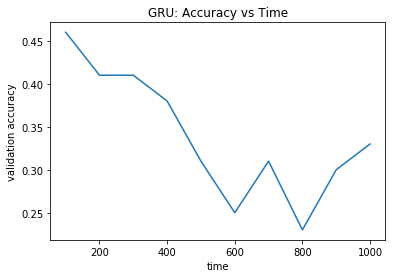

[0.46, 0.41, 0.41, 0.38, 0.31, 0.25, 0.31, 0.23, 0.3, 0.33]


In [37]:
#plt.figure(1)
plt.xlabel('time')
plt.ylabel('validation accuracy')
plt.title('GRU: Accuracy vs Time')
t = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
plt.plot(t, acc_t)
#plt.savefig('t_GRU_test.png')
plt.show()
print (acc_t)

# Best Model Test

In [26]:
#best_model = torch.load('best_CHRONET.pt')
print (model.check_accuracy(dataloaders['test']))

0.79
